Saved overlay GIF: ttfs_gifs_overlay/ttfs_overlay_0.gif
Saved overlay GIF: ttfs_gifs_overlay/ttfs_overlay_1.gif


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 10, 32, 32, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 10, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 10, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,226 (8.37 MB)

 Trainable params: 2,193,226 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2231 - loss: 2.0930 - val_accuracy: 0.4180 - val_loss: 1.6350
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3995 - loss: 1.6738 - val_accuracy: 0.4757 - val_loss: 1.4901
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4505 - loss: 1.5421 - val_accuracy: 0.5164 - val_loss: 1.3818
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4842 - loss: 1.4564 - val_accuracy: 0.5338 - val_loss: 1.3179
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5111 - loss: 1.3892 - val_accuracy: 0.5537 - val_loss: 1.2654
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5315 - loss: 1.3351 - val_accuracy: 0.5667 - val_loss: 1.2224
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5535 - loss: 1.2871 - val_accuracy: 0.5771 - val_loss: 1.1966
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5639 - loss: 1.2541 - val_accuracy: 

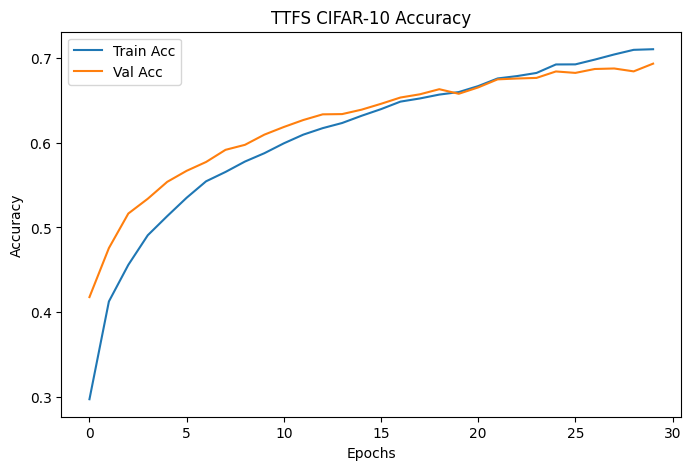

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

# ------------------------------------------------
# 1️⃣ TTFS Encoding Function
# ------------------------------------------------
@tf.function
def TTFS_encode(image, time_steps=10):
    """Time-To-First-Spike (TTFS) encoding for one image [H, W, C]."""
    image = tf.cast(image, tf.float32) / 255.0
    spike_times = (1.0 - image) * (time_steps - 1)
    spike_times = tf.round(spike_times)
    time_range = tf.range(time_steps, dtype=tf.float32)[:, None, None, None]
    spikes = tf.cast(tf.equal(time_range, spike_times[None, ...]), tf.float32)
    return spikes  # shape: [time_steps, H, W, C]


# ------------------------------------------------
# 2️⃣ Load CIFAR-10 Dataset
# ------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10
time_steps = 10
batch_size = 64

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


# ------------------------------------------------
# 3️⃣ Visualization with Spike Overlay + GIF
# ------------------------------------------------
def visualize_and_save_ttfs_overlay(image, label, time_steps=10, save_dir="ttfs_gifs_overlay", sample_id=0):
    """Visualize TTFS spikes overlayed on the original image and save as GIF."""
    os.makedirs(save_dir, exist_ok=True)
    spikes = TTFS_encode(image, time_steps)
    spikes_np = spikes.numpy()  # (time_steps, H, W, C)
    img_norm = image / 255.0

    # Compute spike time map (earliest spikes = bright)
    spike_time_map = np.argmax(spikes_np[::-1], axis=0)
    spike_time_map = time_steps - spike_time_map

    # Static map of spike timing
    plt.figure(figsize=(4, 4))
    plt.imshow(spike_time_map[:, :, 0], cmap="inferno")
    plt.title(f"Spike Timing Map (sample {sample_id})")
    plt.axis("off")
    plt.savefig(os.path.join(save_dir, f"spike_timing_{sample_id}.png"))
    plt.close()

    # Animated GIF: overlay spikes on original image
    frames = []
    for t in range(time_steps):
        # Binary spike mask for this timestep
        mask = spikes_np[t]
        overlay = img_norm.copy()

        # Red overlay for active spikes
        overlay[:, :, 0] = np.clip(overlay[:, :, 0] + 0.8 * mask[:, :, 0], 0, 1)

        frame = (overlay * 255).astype(np.uint8)
        frames.append(frame)

    gif_path = os.path.join(save_dir, f"ttfs_overlay_{sample_id}.gif")
    imageio.mimsave(gif_path, frames, fps=2)  # 2 frames per second
    print(f"Saved overlay GIF: {gif_path}")


# Generate a few overlayed GIFs before training
for i in range(2):
    visualize_and_save_ttfs_overlay(x_train[i], y_train[i], time_steps=time_steps, sample_id=i)


# ------------------------------------------------
# 4️⃣ On-the-Fly tf.data Pipeline
# ------------------------------------------------
def encode_fn(image, label):
    spikes = TTFS_encode(image, time_steps)
    return spikes, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(10000)
    .map(encode_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(encode_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


# ------------------------------------------------
# 5️⃣ Model Definition (TimeDistributed Conv2D)
# ------------------------------------------------
def create_ttfs_cifar10_model(time_steps=10, num_classes=10):
    model = models.Sequential([
        layers.Input(shape=(time_steps, 32, 32, 3)),

        layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.Flatten()),

        # Integrate spike activity over time
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model








In [ ]:
# ------------------------------------------------
# 6️⃣ Train the Model
# ------------------------------------------------
model = create_ttfs_cifar10_model(time_steps, num_classes)
model.summary()



In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7170 - loss: 0.8224 - val_accuracy: 0.6976 - val_loss: 0.8731
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7194 - loss: 0.8073 - val_accuracy: 0.6925 - val_loss: 0.8749
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7215 - loss: 0.7962 - val_accuracy: 0.6921 - val_loss: 0.8764
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7232 - loss: 0.7854 - val_accuracy: 0.6977 - val_loss: 0.8661
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7277 - loss: 0.7722 - val_accuracy: 0.7010 - val_loss: 0.8599
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7338 - loss: 0.7609 - val_accuracy: 0.6981 - val_loss: 0.8666
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7353 - loss: 0.7540 - val_accuracy: 0.7030 - val_loss: 0.8516
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7441 - loss: 0.7310 - val_accuracy: 0.

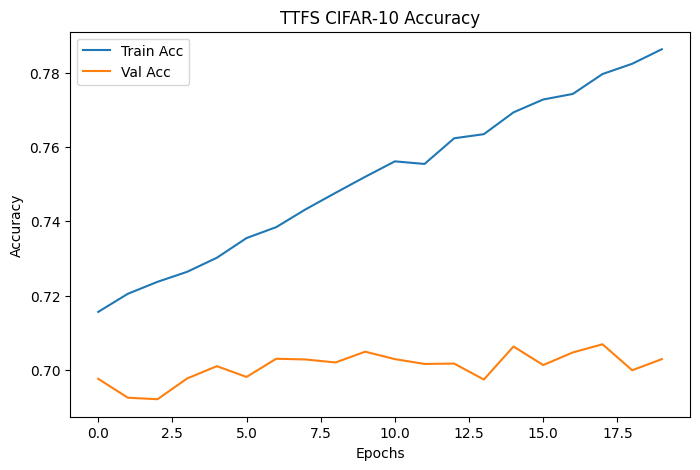

In [ ]:
# ------------------------------------------------
# 7️⃣ Plot Accuracy Curves
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('TTFS CIFAR-10 Accuracy')
plt.legend()
plt.show()